<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Filter_Rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Filter Rules
---
## Load useful packages...

In [1]:
from my_library import *

13:41:59 Starting...
13:41:59 Installing yfinance into Google notebook...
13:42:03 Installing arch into Google notebook...
13:42:14 Initialized.


## Get S&P 500 Index Data from Yahoo! Finance

In [2]:
nprint("Fetching data from Yahoo!...")
data,sname=download(ticker:='SPY','1990-01-02','2019-12-31',auto_adjust=True,progress=False),'S&P 500 Index ETF'
data.columns=data.columns.get_level_values(0)
data.columns.name=ticker
data.index=pd.PeriodIndex(data.index,freq='B')
data['Return']=data['Close'].pct_change()*hundred
data.dropna(inplace=True)
display(data)

13:42:14 Fetching data from Yahoo!...


<ipython-input-2-eadee26bc247>:5: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.PeriodIndex(data.index,freq='B')


SPY,Close,High,Low,Open,Volume,Return
Date,,,,,,
1993-02-01,24.700520,24.700520,24.543525,24.543525,480500,0.711252
1993-02-02,24.752855,24.770299,24.630748,24.683080,201300,0.211881
1993-02-03,25.014511,25.031955,24.770297,24.787741,529400,1.057073
1993-02-04,25.119177,25.171508,24.822631,25.101733,531500,0.418420
1993-02-05,25.101721,25.154052,24.962170,25.101721,492100,-0.069493
...,...,...,...,...,...,...
2019-12-23,297.810883,298.209539,297.662539,298.153914,52990000,0.152774
2019-12-24,297.820190,298.089036,297.514224,298.042691,20270000,0.003125
2019-12-26,299.405609,299.414889,298.200359,298.209611,30911200,0.532341


## Fit baseline AR(1) GJR-AGARCH(1,1) model

In [3]:
from arch.univariate import ARX
model = ARX(data['Return'],lags=1)
model.volatility = GARCH2(0,1,1)
model.distribution = GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
display(baseline:=pd.DataFrame([fit.params,fit.std_err]).T)
data['Volatility']=fit.conditional_volatility
data['Alpha']=baseline.loc['Const','params']+baseline.loc['Return[1]','params']*data['Return'].shift()
data['Z Score']=(data['Return']-data['Alpha'])/data['Volatility'].shift()
display(data)
nprint("Baseline IC %.2f %%." % (hundred*fit.rsquared**half))

13:42:16
                               AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.003
Mean Model:                                    AR   Adj. R-squared:                  0.003
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8759.18
Distribution:      Generalized Error Distribution   AIC:                           17530.4
Method:                        Maximum Likelihood   BIC:                           17571.3
                                                    No. Observations:                 6777
Date:                            Fri, Mar 21 2025   Df Residuals:                     6775
Time:                                    13:42:16   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------

,params,std_err
Const,0.062286,0.009136
Return[1],-0.037914,0.013219
omega,0.017251,0.003156
gamma[1],0.187389,0.021784
beta[1],0.888963,0.011779
nu,1.348240,0.036889


SPY,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score
Date,,,,,,,,,
1993-02-01,24.700520,24.700520,24.543525,24.543525,480500,0.711252,NaN,NaN,NaN
1993-02-02,24.752855,24.770299,24.630748,24.683080,201300,0.211881,0.783960,0.035319,NaN
1993-02-03,25.014511,25.031955,24.770297,24.787741,529400,1.057073,0.750735,0.054253,1.279173
1993-02-04,25.119177,25.171508,24.822631,25.101733,531500,0.418420,0.719912,0.022208,0.527766
1993-02-05,25.101721,25.154052,24.962170,25.101721,492100,-0.069493,0.691359,0.046422,-0.161012
...,...,...,...,...,...,...,...,...,...
2019-12-23,297.810883,298.209539,297.662539,298.153914,52990000,0.152774,0.484165,0.045664,0.216710
2019-12-24,297.820190,298.089036,297.514224,298.042691,20270000,0.003125,0.475014,0.056494,-0.110227
2019-12-26,299.405609,299.414889,298.200359,298.209611,30911200,0.532341,0.467300,0.062167,0.989810


13:42:16 Baseline IC 5.46 %.


## Fit a Basic "Filter Rules" Model

In [4]:
# create filter rules summary holder, re-run this cell to reset dataframe
from itertools import product
summary=pd.DataFrame({tuple(x):[] for x in product(['Active','Inactive'],['Mean','St.Dev.','Count','Std.Err.'])},index=pd.Series([],name='Filter'))

14:22:58 Creating filter rule indicators with order 4 and offset 0.100000.
14:22:58 Conditional returns:


SPY,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score,Direction,...,Filter_0110,Filter_0111,Filter_1000,Filter_1001,Filter_1010,Filter_1011,Filter_1100,Filter_1101,Filter_1110,Filter_1111
Date,,,,,,,,,,,,,,,,,,,,,
1993-02-01,24.700520,24.700520,24.543525,24.543525,480500,0.711252,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-02,24.752855,24.770299,24.630748,24.683080,201300,0.211881,0.783960,0.035319,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-03,25.014511,25.031955,24.770297,24.787741,529400,1.057073,0.750735,0.054253,1.279173,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-04,25.119177,25.171508,24.822631,25.101733,531500,0.418420,0.719912,0.022208,0.527766,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-05,25.101721,25.154052,24.962170,25.101721,492100,-0.069493,0.691359,0.046422,-0.161012,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,297.810883,298.209539,297.662539,298.153914,52990000,0.152774,0.484165,0.045664,0.216710,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-24,297.820190,298.089036,297.514224,298.042691,20270000,0.003125,0.475014,0.056494,-0.110227,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-12-26,299.405609,299.414889,298.200359,298.209611,30911200,0.532341,0.467300,0.062167,0.989810,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Active                               Inactive            \
              Count      Mean   St.Dev.  Std.Err.    Count      Mean   
Rule                                                                   
Filter_000    590.0  0.206879  1.566589  0.064495   6188.0  0.027767   
Filter_0000   233.0  0.305404  1.870371  0.122532   6545.0  0.034029   
Filter_1010   274.0  0.172449  0.985779  0.059553   6504.0  0.037919   
Filter_00    1356.0  0.113985  1.419231  0.038541   5422.0  0.025694   
Filter_101    598.0  0.102463  1.025833  0.041949   6180.0  0.037639   
Filter_0001   297.0  0.134775  1.340142  0.077763   6481.0  0.039168   
Filter_0     3001.0  0.061619  1.268203  0.023150   3777.0  0.028848   
Filter_110    671.0  0.055102  0.928624  0.035849   6107.0  0.042067   
Filter_1101   284.0  0.060777  0.896947  0.053224   6494.0  0.042596   
Filter_0111   273.0  0.058928  0.911769  0.055183   6505.0  0.042704   
Filter_001    642.0  0.053380  1.297860  0.051222   6136.0  0.042309   
Filter_0010   289.0  0.060665  1.487484  0.087499   6489.0  0.042587   
Filter_1011   272.0  0.056045  1.054030  0.063910   6506.0  0.042827   
Filter_0101   259.0  0.049286  1.030173  0.064012   6519.0  0.043122   
Filter_10    1418.0  0.044906  1.127285  0.029936   5360.0  0.042948   
Filter_0011   292.0  0.043486  1.152295  0.067433   6486.0  0.043352   
Filter_011    604.0  0.031710  0.981933  0.039954   6174.0  0.044497   
Filter_1100   316.0  0.017296  0.952074  0.053558   6462.0  0.044632   
Filter_0110   273.0  0.008464  1.083522  0.065578   6505.0  0.044822   
Filter_1001   301.0 -0.012612  1.288125  0.074246   6477.0  0.045959   
Filter_1110   300.0 -0.000784  0.954045  0.055082   6478.0  0.045402   
Filter_1     3103.0  0.030226  1.019573  0.018303   3675.0  0.054446   
Filter_11    1392.0  0.018364  0.913857  0.024494   5386.0  0.049817   
Filter_1000   315.0 -0.036247  1.252119  0.070549   6463.0  0.047238   
Filter_100    669.0 -0.010808  1.254632  0.048507   6109.0  0.049290   
Filter_010    620.0 -0.016510  1.187712  0.047700   6158.0  0.049385   
Filter_0100   298.0 -0.094041  1.363499  0.078985   6480.0  0.049676   
Filter_01    1344.0 -0.005583  1.100715  0.030024   5434.0  0.055462   
Filter_1111   227.0 -0.080587  0.946993  0.062854   6551.0  0.047653   
Filter_111    586.0 -0.031906  0.921587  0.038070   6192.0  0.050481   

                                  Z Score  
              St.Dev.  Std.Err.            
Rule                                       
Filter_000   1.092095  0.013883  2.714941  
Filter_0000  1.106610  0.013679  2.201052  
Filter_1010  1.148099  0.014236  2.197080  
Filter_00    1.061140  0.014411  2.145729  
Filter_101   1.152783  0.014664  1.458746  
Filter_0001  1.132275  0.014065  1.209834  
Filter_0     1.031169  0.016779  1.146181  
Filter_110   1.163366  0.014887  0.335785  
Filter_1101  1.151813  0.014293  0.329901  
Filter_0111  1.150944  0.014270  0.284639  
Filter_001   1.124816  0.014359  0.208103  
Filter_0010  1.124532  0.013960  0.204030  
Filter_1011  1.145840  0.014206  0.201889  
Filter_0101  1.146526  0.014200  0.094003  
Filter_10    1.146254  0.015657  0.057951  
Filter_0011  1.141863  0.014178  0.001941  
Filter_011   1.156782  0.014722 -0.300299  
Filter_1100  1.150769  0.014315 -0.493094  
Filter_0110  1.144683  0.014193 -0.541885  
Filter_1001  1.135038  0.014103 -0.775008  
Filter_1110  1.150219  0.014291 -0.811632  
Filter_1     1.236386  0.020395 -0.883834  
Filter_11    1.194159  0.016272 -1.069626  
Filter_1000  1.136565  0.014138 -1.160285  
Filter_100   1.129194  0.014447 -1.187407  
Filter_010   1.137474  0.014495 -1.321775  
Filter_0100  1.130736  0.014047 -1.791433  
Filter_01    1.152044  0.015628 -1.803506  
Filter_1111  1.148220  0.014186 -1.990208  
Filter_111   1.160749  0.014751 -2.017870

<ipython-input-13-7967cd63ac8f>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(x,rotation=90,fontsize=12)


14:23:00 Saved figure to '/content/drive/MyDrive/Subsequent Return Associated with Filter Rules.png'.


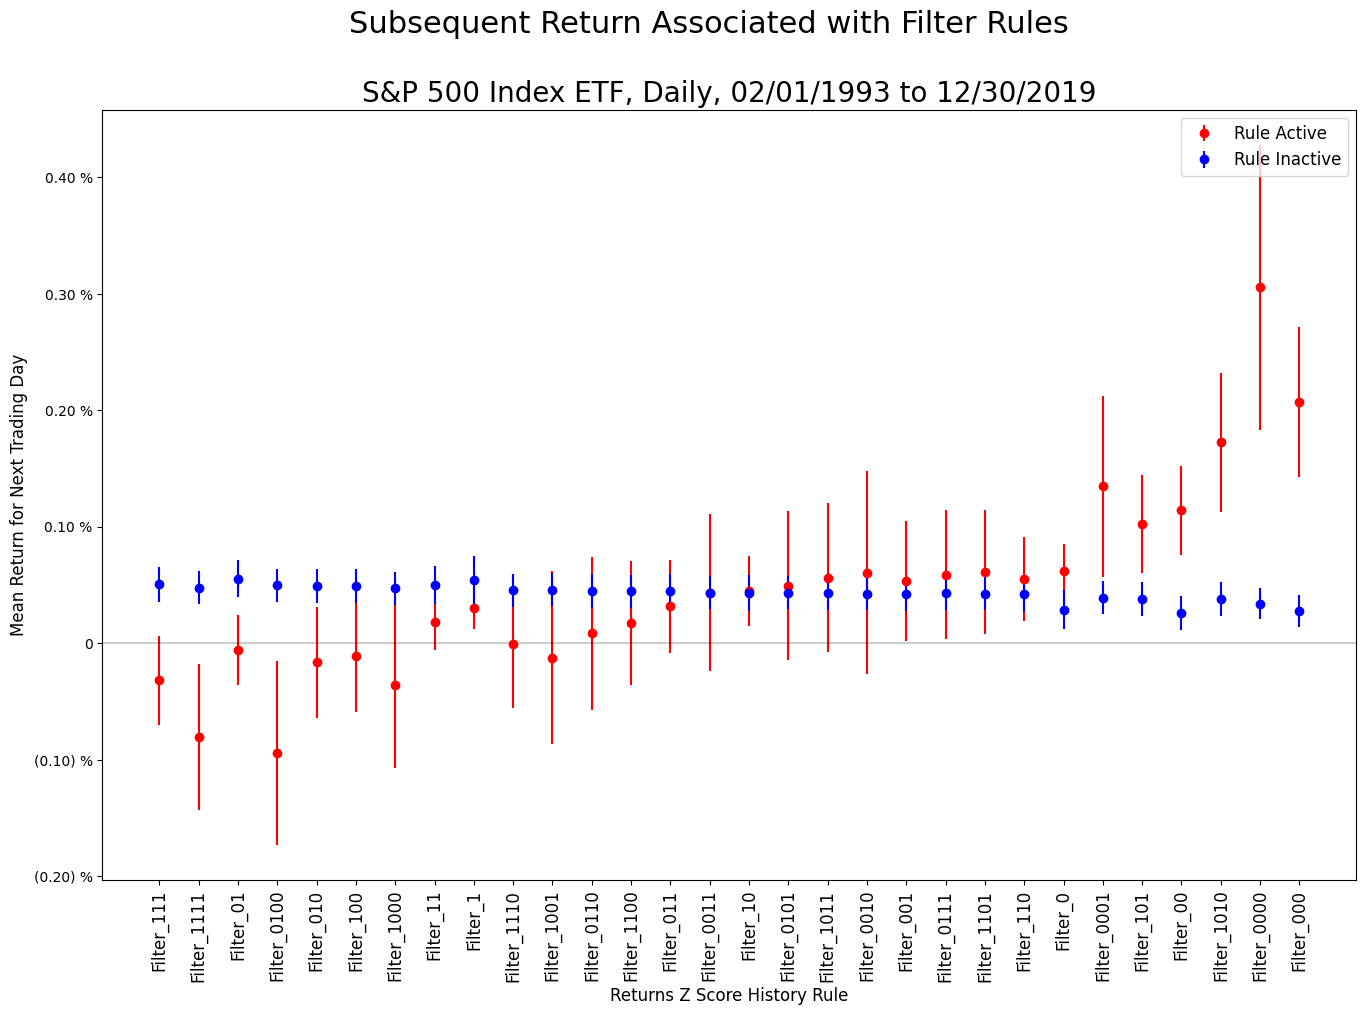

In [13]:
nprint("Creating filter rule indicators with order {:d} and offset {:f}.".format(forder:=4,foffset:=0.1))

data['Direction']=data['Z Score'].apply(lambda x: one if x>foffset else -one if x<-foffset else zero)
data.drop(data.columns[data.columns.str.contains('Filter')],axis=1,inplace=True)

for lag in range(1,forder+1):
    data['Z_'+str(lag)]=data['Z Score'].shift(lag)
    data['Direction_'+str(lag)]=data['Direction'].shift(lag)

for rule in range(2**forder):
    rmap=list(map(lambda x:-one if x=='0' else +one,label:="{:0#b}".replace("#",str(forder)).format(rule)))
    data['Filter_'+label]=(data['Direction_1']==rmap[0])

    for lag in range(2,forder+1):
        data['Filter_'+label]&=(data['Direction_'+str(lag)]==rmap[lag-1])

    data['Filter_'+label]=data['Filter_'+label].apply(lambda x:one if x else zero)

nprint("Conditional returns:")
display(data)

for f in data.columns[data.columns.str.contains('Filter')]:
    g=data[[f,'Return']].groupby(f)
    summary.loc[f,('Active','Mean')]=g.mean().loc[one,'Return']
    summary.loc[f,('Inactive','Mean')]=g.mean().loc[zero,'Return']
    summary.loc[f,('Active','St.Dev.')]=g.std().loc[one,'Return']
    summary.loc[f,('Inactive','St.Dev.')]=g.std().loc[zero,'Return']
    summary.loc[f,('Active','Count')]=g.count().loc[one,'Return']
    summary.loc[f,('Inactive','Count')]=g.count().loc[zero,'Return']

    for s in [c for c in set(summary.columns.get_level_values(0)) if c!='Z Score']:
        summary.loc[f,(s,'Std.Err.')]=summary.loc[f,(s,'St.Dev.')]/np.sqrt(summary.loc[f,(s,'Count')])

summary=summary[sorted(summary.columns)].copy()
summary['Z Score']=(summary['Active','Mean']-summary['Inactive','Mean'])/np.sqrt(summary['Active','Std.Err.']**two+summary['Inactive','Std.Err.']**two)
summary.index.name='Rule'
display(summary.sort_values('Z Score',ascending=False))

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=summary.sort_values('Z Score').index,y:=summary.loc[x,('Active','Mean')],ye:=summary.loc[x,('Active','Std.Err.')],fmt='o',color='red',label='Rule Active')
plot.errorbar(x,y:=summary.loc[x,('Inactive','Mean')],ye:=summary.loc[x,('Inactive','Std.Err.')],fmt='o',color='blue',label='Rule Inactive')
plot.set_xticklabels(x,rotation=90,fontsize=12)
plot.set_ylabel('Mean Return for Next Trading Day',fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel('Returns Z Score History Rule',fontsize=12)
plot.axhline(color='black',alpha=0.2)
figure.suptitle(title:='Subsequent Return Associated with Filter Rules',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)
plot.legend(fontsize=12)
figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

13:42:21 Fitting GJR-GARCH model with filter rules...
13:42:22
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.000
Mean Model:                                  AR-X   Adj. R-squared:                 -0.000
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8760.26
Distribution:      Generalized Error Distribution   AIC:                           17534.5
Method:                        Maximum Likelihood   BIC:                           17582.3
                                                    No. Observations:                 6775
Date:                            Fri, Mar 21 2025   Df Residuals:                     6772
Time:                                    13:42:22   Df Model:                            3
                                  Mean Model                                 
                 coef    std err        

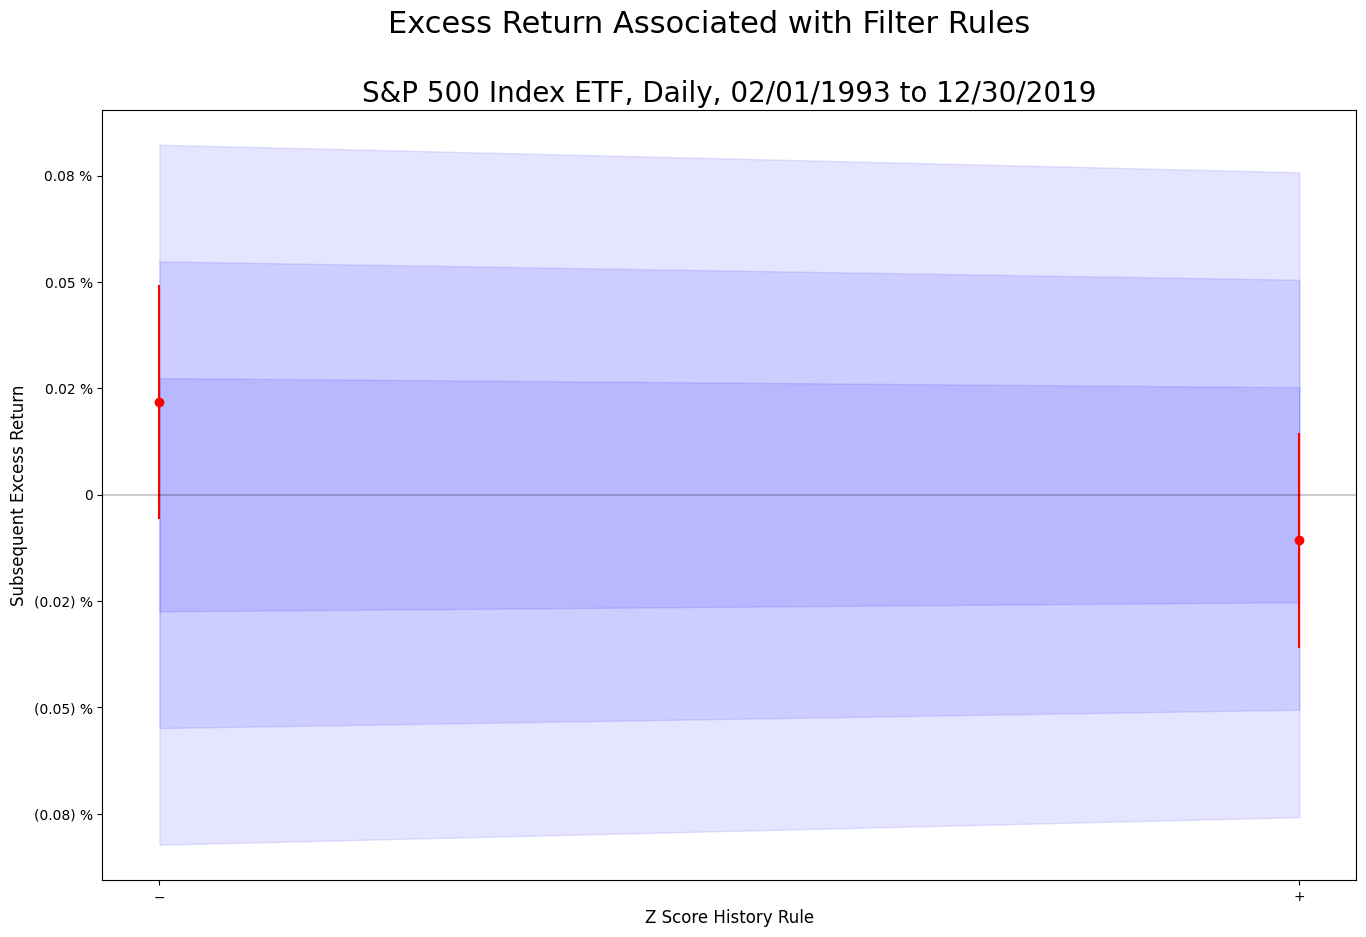

In [6]:
nprint("Fitting GJR-GARCH model with filter rules...")
model=ARX((design:=data.dropna())['Return'],design[fcols:=design.columns[design.columns.str.contains('Filter')]])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
coefficients=pd.DataFrame([fit.params[fcols],fit.std_err[fcols]]).T

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=list(map(lambda l:l.replace('Filter_','').replace('0','$-$').replace('1','$+$'),coefficients.index)),y:=coefficients['params'],ye:=coefficients['std_err'],fmt='o',color='red')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel('Subsequent Excess Return',fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel('Z Score History Rule',fontsize=12)
figure.suptitle(title:='Excess Return Associated with Filter Rules',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)

for s in range(1,4):
    plot.fill_between(x,-s*ye,y2=s*ye,alpha=0.1,color='blue')

figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

### Fit a Conditional Model to (Filter_000 | Filter_111)

In [7]:
nprint("Fitting a hybrid conditional autoregression...")
data['Conditional']=(data['Filter_000'].astype(bool)|data['Filter_111'].astype(bool)).astype(float)*data['Return'].shift()
model=ARX((design:=data.dropna())['Return'],design['Conditional'])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
nprint("In-sample IC is (%.2f +/- %.2f) %%" % (-data[['Return','Conditional']].replace(zero,np.nan).dropna().corr().iloc[0,1]*hundred,hundred/np.sqrt(data[['Return','Conditional']].replace(zero,np.nan).dropna().shape[0]-three)))

13:42:28 Fitting a hybrid conditional autoregression...


KeyError: 'Filter_000'

### Formulas for Article

$$
\alpha_t=\mathbb{E}[r_t|\mathcal{I}_s]:s<t
$$

$$
\alpha_t=f(\mathcal{I}_s)
$$

$$
f(\mathcal{I}_s)=\mu+\varphi r_{t-1}+\dots
$$

$$
\lim_{t\rightarrow\infty}\mathbb{E}[\alpha_t]=\mathbb{E}[r_t]
$$

$$
\overline{\{r_s : s<t\}}
$$

$$
\begin{align}
r_t&=\mu+\varphi r_{t-1}+\sigma_t\varepsilon_t\\
\sigma_t^2&=C+B\sigma_{t-1}^2+Dr_{t-1}^2\mathbb{I}[r_{t-1}<0]\\
\varepsilon_t&\sim\mathop{\mathrm{GED}}(\kappa)
\end{align}
$$
